1. Загрузите выборку из файла gbm-data.csv с помощью pandas и преобразуйте ее в массив numpy (параметр values у датафрейма). В первой колонке файла с данными записано, была или нет реакция. Все остальные колонки (d1 - d1776) содержат различные характеристики молекулы, такие как размер, форма и т.д. Разбейте выборку на обучающую и тестовую, используя функцию train_test_split с параметрами test_size = 0.8 и random_state = 241.

2. Обучите GradientBoostingClassifier с параметрами n_estimators=250, verbose=True, random_state=241 и для каждого значения learning_rate из списка [1, 0.5, 0.3, 0.2, 0.1] проделайте следующее:
     * Используйте метод staged_decision_function для предсказания качества на обучающей и тестовой выборке на каждой итерации.
     * Преобразуйте полученное предсказание с помощью сигмоидной функции по формуле 1 / (1 + e^{−y_pred}), где y_pred — предсказанное значение.
     * Вычислите и постройте график значений log-loss (которую можно посчитать с помощью функции sklearn.metrics.log_loss) на обучающей и тестовой выборках, а также найдите минимальное значение метрики и номер итерации, на которой оно достигается.
     
3. Как можно охарактеризовать график качества на тестовой выборке, начиная с некоторой итерации: переобучение (overfitting) или недообучение (underfitting)? В ответе укажите одно из слов overfitting либо underfitting.

4. Приведите минимальное значение log-loss на тестовой выборке и номер итерации, на котором оно достигается, при learning_rate = 0.2.

5. На этих же данных обучите RandomForestClassifier с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего пункта, c random_state=241 и остальными параметрами по умолчанию. Какое значение log-loss на тесте получается у этого случайного леса? (Не забывайте, что предсказания нужно получать с помощью функции predict_proba. В данном случае брать сигмоиду от оценки вероятности класса не нужно)

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from typing import List, Tuple

%matplotlib inline

### 1. Загрузите выборку из файла gbm-data.csv с помощью pandas и преобразуйте ее в массив numpy (параметр values у датафрейма). В первой колонке файла с данными записано, была или нет реакция. Все остальные колонки (d1 - d1776) содержат различные характеристики молекулы, такие как размер, форма и т.д. Разбейте выборку на обучающую и тестовую, используя функцию train_test_split с параметрами test_size = 0.8 и random_state = 241.

In [3]:
df = pd.read_csv("gbm-data.csv")
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = df.loc[:, "D1":"D1776"].values
y = df["Activity"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

### 2. Обучите GradientBoostingClassifier с параметрами n_estimators=250, verbose=True, random_state=241 и для каждого значения learning_rate из списка [1, 0.5, 0.3, 0.2, 0.1] проделайте следующее:
 * Используйте метод staged_decision_function для предсказания качества на обучающей и тестовой выборке на каждой итерации.
 * Преобразуйте полученное предсказание с помощью сигмоидной функции по формуле 1 / (1 + e^{−y_pred}), где y_pred — предсказанное значение.
 * Вычислите и постройте график значений log-loss (которую можно посчитать с помощью функции sklearn.metrics.log_loss) на обучающей и тестовой выборках, а также найдите минимальное значение метрики и номер итерации, на которой оно достигается.

In [6]:
def sigmoid(y_pred: np.array) -> np.array:
    return 1.0 / (1.0 + np.exp(-y_pred))

In [7]:
def log_loss_results(model, X: np.array, y: np.array) -> List[float]:
    return [log_loss(y, sigmoid(y_pred)) for y_pred in model.staged_decision_function(X)]

Learning rate: 1
      Iter       Train Loss   Remaining Time 
         1           1.0190           16.78s
         2           0.9192           15.73s
         3           0.8272           15.36s
         4           0.7834           14.26s
         5           0.7109           13.85s
         6           0.6368           13.84s
         7           0.5797           13.60s
         8           0.5610           13.44s
         9           0.5185           13.47s
        10           0.4984           13.46s
        20           0.1999           12.93s
        30           0.1313           11.62s
        40           0.0790           12.85s
        50           0.0511           12.24s
        60           0.0352           11.31s
        70           0.0245           10.46s
        80           0.0162            9.71s
        90           0.0114            9.02s
       100           0.0077            8.39s
       200           0.0004            2.39s


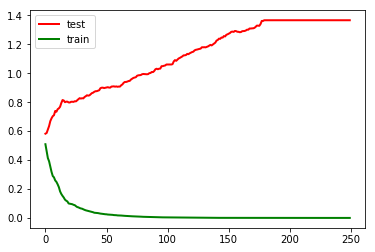

Min loss 0.58 at n_estimators=1

Learning rate: 0.5
      Iter       Train Loss   Remaining Time 
         1           1.1255           15.41s
         2           1.0035           15.24s
         3           0.9386           15.20s
         4           0.8844           14.80s
         5           0.8381           14.37s
         6           0.7995           13.89s
         7           0.7559           13.65s
         8           0.7205           13.54s
         9           0.6958           13.27s
        10           0.6725           13.15s
        20           0.4672           12.03s
        30           0.3179           11.46s
        40           0.2274           10.97s
        50           0.1774           10.35s
        60           0.1394            9.91s
        70           0.1050            9.37s
        80           0.0805            8.82s
        90           0.0650            8.24s
       100           0.0511            7.74s
       200           0.0058            2.53s


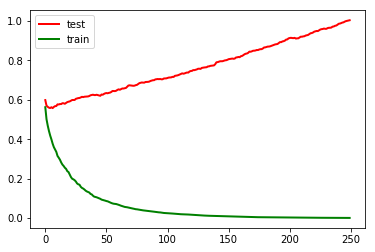

Min loss 0.56 at n_estimators=7

Learning rate: 0.3
      Iter       Train Loss   Remaining Time 
         1           1.2095           15.14s
         2           1.1006           15.09s
         3           1.0240           15.44s
         4           0.9729           15.49s
         5           0.9387           14.68s
         6           0.8948           14.63s
         7           0.8621           14.46s
         8           0.8360           14.08s
         9           0.8171           13.75s
        10           0.7883           13.53s
        20           0.6164           12.37s
        30           0.4933           11.56s
        40           0.4248           10.86s
        50           0.3345           10.36s
        60           0.2760            9.82s
        70           0.2263            9.30s
        80           0.1971            8.71s
        90           0.1693            8.16s
       100           0.1388            7.67s
       200           0.0294            3.10s


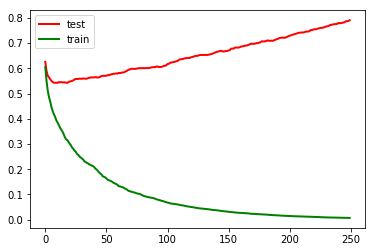

Min loss 0.54 at n_estimators=11

Learning rate: 0.2
      Iter       Train Loss   Remaining Time 
         1           1.2613           16.20s
         2           1.1715           15.64s
         3           1.1009           15.70s
         4           1.0529           15.36s
         5           1.0130           15.26s
         6           0.9740           15.07s
         7           0.9475           14.64s
         8           0.9197           14.57s
         9           0.8979           14.18s
        10           0.8730           14.11s
        20           0.7207           12.58s
        30           0.6055           11.82s
        40           0.5244           11.11s
        50           0.4501           10.48s
        60           0.3908           10.03s
        70           0.3372            9.52s
        80           0.3009            9.06s
        90           0.2603            8.52s
       100           0.2327            7.94s
       200           0.0835            2.62s


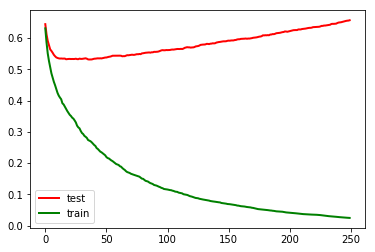

Min loss 0.53 at n_estimators=37

Learning rate: 0.1
      Iter       Train Loss   Remaining Time 
         1           1.3199           15.13s
         2           1.2645           15.23s
         3           1.2170           15.96s
         4           1.1775           15.61s
         5           1.1404           15.49s
         6           1.1106           15.29s
         7           1.0844           15.24s
         8           1.0617           15.09s
         9           1.0411           14.94s
        10           1.0223           14.85s
        20           0.8864           13.42s
        30           0.7844           12.28s
        40           0.7176           11.45s
        50           0.6590           10.81s
        60           0.6120           10.13s
        70           0.5599            9.53s
        80           0.5242            8.91s
        90           0.4829            8.64s
       100           0.4473            8.06s
       200           0.2379            2.81s


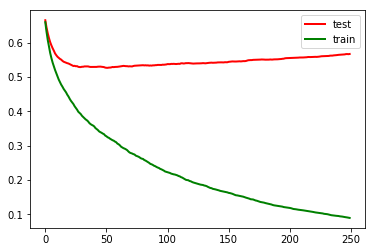

Min loss 0.53 at n_estimators=52



In [8]:
def plot_loss(learning_rate: float, test_loss: List[float], train_loss: List[float]) -> None:
    plt.figure()
    plt.plot(test_loss, "r", linewidth=2)
    plt.plot(train_loss, "g", linewidth=2)
    plt.legend(["test", "train"])
    plt.show()

min_loss_results = {}
for lr in [1, 0.5, 0.3, 0.2, 0.1]:
    print(f"Learning rate: {lr}")

    model = GradientBoostingClassifier(learning_rate=lr, n_estimators=250, verbose=True, random_state=241)
    model.fit(X_train, y_train)
    
    train_loss = log_loss_results(model, X_train, y_train)
    test_loss = log_loss_results(model, X_test, y_test)
    plot_loss(lr, test_loss, train_loss)
    
    min_loss_value = min(test_loss)
    min_loss_index = test_loss.index(min_loss_value) + 1
    min_loss_results[lr] = min_loss_value, min_loss_index

    print(f"Min loss {min_loss_value:.2f} at n_estimators={min_loss_index}\n")

### 3. Как можно охарактеризовать график качества на тестовой выборке, начиная с некоторой итерации: переобучение (overfitting) или недообучение (underfitting)? В ответе укажите одно из слов overfitting либо underfitting.

In [9]:
print("overfitting")

overfitting


### 4. Приведите минимальное значение log-loss на тестовой выборке и номер итерации, на котором оно достигается, при learning_rate = 0.2.

In [11]:
min_loss_value, min_loss_index = min_loss_results[0.2]
print(f"{min_loss_value:.2f} {min_loss_index}")

0.53 37


### 5. На этих же данных обучите RandomForestClassifier с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего пункта, c random_state=241 и остальными параметрами по умолчанию. Какое значение log-loss на тесте получается у этого случайного леса? (Не забывайте, что предсказания нужно получать с помощью функции predict_proba. В данном случае брать сигмоиду от оценки вероятности класса не нужно)

In [12]:
model = RandomForestClassifier(n_estimators=min_loss_index, random_state=241)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:, 1]
test_loss = log_loss(y_test, y_pred)

print(f"{test_loss:.2f}")

0.54
